In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("22IT085_Pre-processed_Dataset.csv")  # Replace with your CSV file name
train_df = df.sample(frac=0.8, random_state=42)  # 80% of the data
test_df = df.drop(train_df.index)  # Remaining 20% of the data

# Save the two parts as separate CSV files
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

print("CSV files saved: train.csv (80%), test.csv (20%)")


CSV files saved: train.csv (80%), test.csv (20%)


In [6]:
!pip install openpyxl

Removed highly correlated columns: ['char_repeat_hostname', 'char_repeat_path', 'shortest_word_hostname', 'longest_word_hostname', 'average_word_length_hostname', 'email_in_url', 'vowel_count_in_domain', 'domain_lookup_response_time', 'nameservers_count', 'number_of_parameters', 'dns_record_check']
Cleaned dataset shape: (10000, 104)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 15)             │         1,575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 104)            │         1,664 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,239 (12.65 KB)

 Trainable params: 3,239 (12.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - loss: 0.0971 - mae: 0.2476 - reconstruction_accuracy: 0.8879 - val_loss: 0.0116 - val_mae: 0.0500 - val_reconstruction_accuracy: 0.9841
Epoch 2/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 0.0102 - mae: 0.0454 - reconstruction_accuracy: 0.9850 - val_loss: 0.0082 - val_mae: 0.0390 - val_reconstruction_accuracy: 0.9869
Epoch 3/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 0.0072 - mae: 0.0369 - reconstruction_accuracy: 0.9880 - val_loss: 0.0058 - val_mae: 0.0323 - val_reconstruction_accuracy: 0.9897
Epoch 4/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.0052 - mae: 0.0307 - reconstruction_accuracy: 0.9902 - val_loss: 0.0046 - val_mae: 0.0282 - val_reconstruction_accuracy: 0.9906
Epoch 5/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.0042 - mae: 0.0271 - reconstruction_accuracy: 0.9909 - val_loss: 0.0039 - val_mae: 0.0252 - val_reconstruction_accuracy: 0.9912
Epoch 6/500
500/500 ━━━━━━━━━━━━━━━

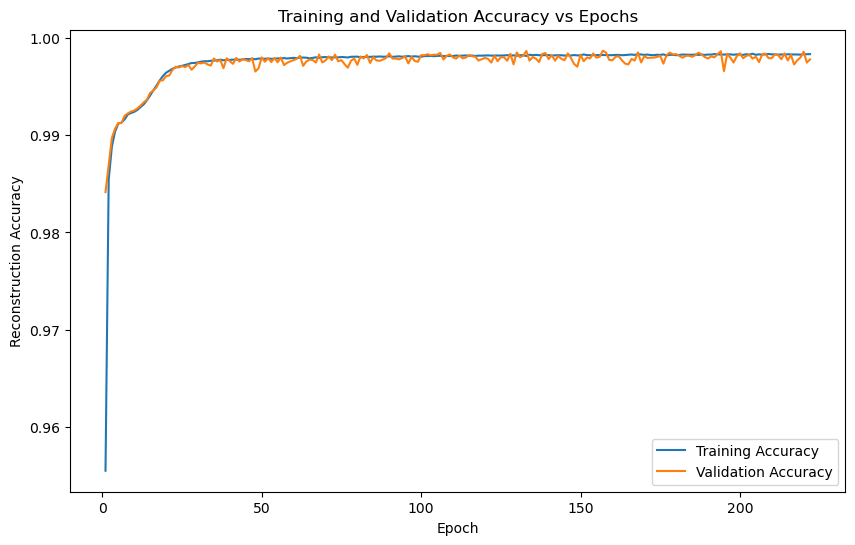

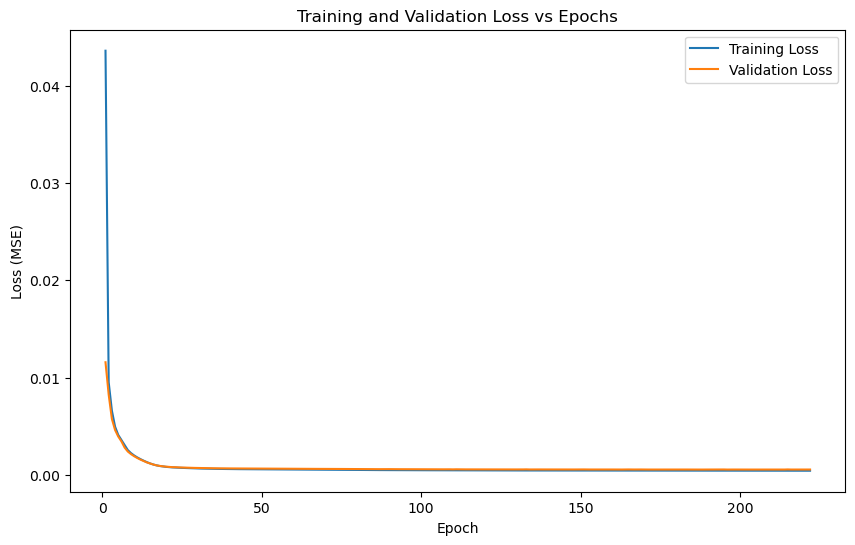

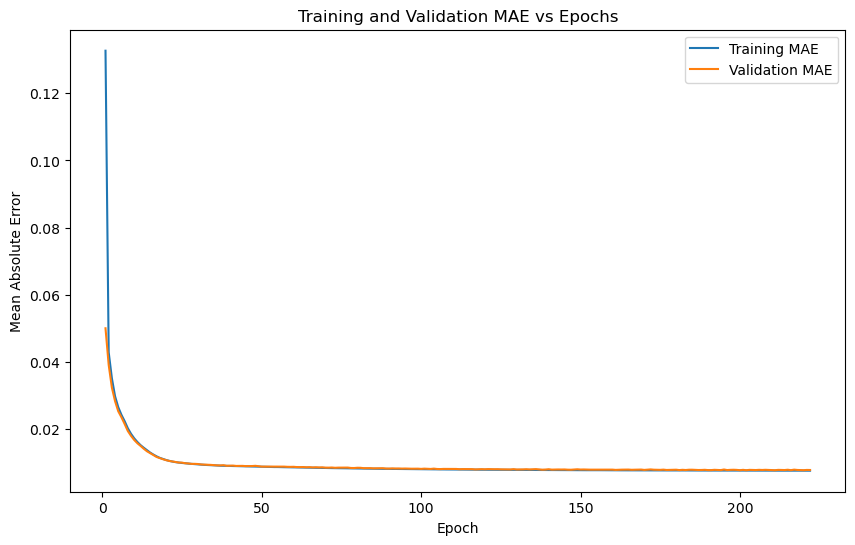

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step


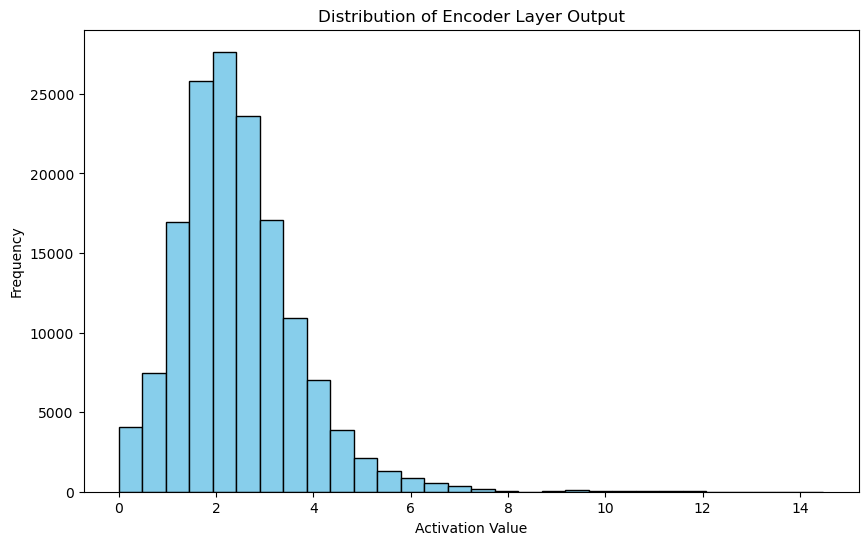

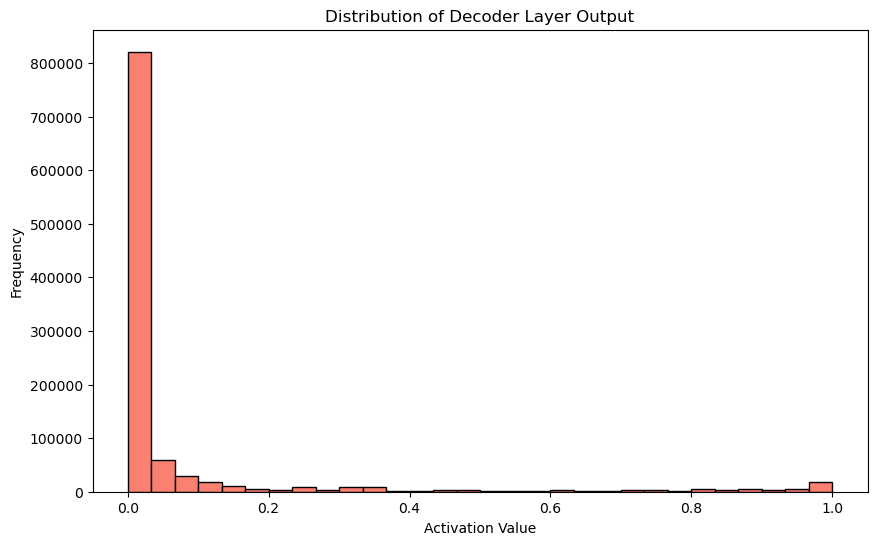

Encoder model saved as 'encoder_model.h5'


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# -----------------------
# Define a custom reconstruction accuracy metric.
# This metric thresholds the true and predicted values at 0.5 and
# calculates the proportion of features that exactly match.
# -----------------------
def reconstruction_accuracy(y_true, y_pred):
    y_true_bin = tf.cast(y_true > 0.5, tf.float32)
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    equal = tf.equal(y_true_bin, y_pred_bin)
    return tf.reduce_mean(tf.cast(equal, tf.float32))

# -----------------------
# Define a custom callback to measure epoch time.
# -----------------------
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.times = []
        self.cumulative_times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_time_start
        self.times.append(epoch_time)
        # Calculate cumulative time
        if self.cumulative_times:
            cum_time = self.cumulative_times[-1] + epoch_time
        else:
            cum_time = epoch_time
        self.cumulative_times.append(cum_time)

# -----------------------
# Load training data from train.csv
# -----------------------
# Assume train.csv has 97 features, with the last column as target.
df_train = pd.read_csv("train.csv").iloc[:10000, :]
target_col = df_train.columns[-1]
features = df_train.drop(columns=target_col)
target = df_train[target_col]

# (Optional) Remove highly correlated features if needed
corr_matrix = features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
threshold = 0.9
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
features_final = features.drop(columns=to_drop)
print("Removed highly correlated columns:", to_drop)

# Save cleaned dataset if needed
df_clean = features_final.copy()
df_clean.to_csv("cleaned_dataset.csv", index=False)
print("Cleaned dataset shape:", df_clean.shape)

# Convert features to numpy array and scale them between 0 and 1
X = df_clean.values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------
# Define the autoencoder model
# -----------------------
input_dim = X_scaled.shape[1]
encoding_dim = 15

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
# We add two metrics: MAE and our custom reconstruction accuracy.
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae', reconstruction_accuracy])
autoencoder.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Instantiate our time recording callback
time_history = TimeHistory()

# -----------------------
# Train the model and measure training time
# -----------------------
start_time = time.time()
history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=500,
                          batch_size=16,
                          shuffle=True,
                          validation_split=0.2,
                          callbacks=[early_stopping, time_history],
                          verbose=1)
total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

# Save overall training time to an Excel file
df_total_time = pd.DataFrame({"TotalTrainingTimeSeconds": [total_training_time]})
df_total_time.to_excel("studentname-regnumber-trainingtime.xlsx", index=False)

# -----------------------
# Save training metrics (excluding time metrics) per epoch to an Excel file.
# -----------------------
epochs = range(1, len(history.history['loss']) + 1)
df_metrics = pd.DataFrame({
    "Epoch": epochs,
    "TrainingLoss": history.history['loss'],
    "ValidationLoss": history.history['val_loss'],
    "TrainingMAE": history.history['mae'],
    "ValidationMAE": history.history['val_mae'],
    "TrainingAccuracy": history.history['reconstruction_accuracy'],
    "ValidationAccuracy": history.history['val_reconstruction_accuracy']
})
print(df_metrics)

# Write training metrics into one Excel file with two sheets.
with pd.ExcelWriter("studentname-regnumber-trainingmetrics.xlsx") as writer:
    df_metrics.to_excel(writer, sheet_name="All_Metrics", index=False)
    df_accuracy = pd.DataFrame({
         "Epoch": epochs,
         "TrainingAccuracy": history.history['reconstruction_accuracy'],
         "ValidationAccuracy": history.history['val_reconstruction_accuracy']
    })
    df_accuracy.to_excel(writer, sheet_name="Accuracy", index=False)

# -----------------------
# Save time-related metrics (epoch time and cumulative time) to a different Excel file.
# -----------------------
df_time = pd.DataFrame({
    "Epoch": epochs,
    "EpochTimeSeconds": time_history.times,
    "CumulativeTimeSeconds": time_history.cumulative_times
})
df_time.to_excel("studentname-regnumber-epochtime.xlsx", index=False)

# -----------------------
# Plot metrics vs. epochs and save the graphs
# -----------------------

# Plot reconstruction accuracy vs epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['reconstruction_accuracy'], label="Training Accuracy")
plt.plot(epochs, history.history['val_reconstruction_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Accuracy")
plt.title("Training and Validation Accuracy vs Epochs")
plt.legend()
plt.savefig("studentname-regnumber-accuracygraph.jpeg")
plt.show()

# Plot loss vs epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['loss'], label="Training Loss")
plt.plot(epochs, history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss vs Epochs")
plt.legend()
plt.savefig("studentname-regnumberlossgraph.jpeg")
plt.show()

# Plot MAE vs epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['mae'], label="Training MAE")
plt.plot(epochs, history.history['val_mae'], label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Training and Validation MAE vs Epochs")
plt.legend()
plt.savefig("studentname-regnumber-maegraph.jpeg")
plt.show()

# -----------------------
# Print output plots for each layer (encoder and decoder)
# -----------------------
# Create the encoder model
encoder_model = Model(inputs=input_layer, outputs=encoder)
# Get the encoder (compressed) output
encoder_output = encoder_model.predict(X_scaled)
# Get the decoder (reconstructed) output from the full autoencoder
decoder_output = autoencoder.predict(X_scaled)

# Plot the distribution of encoder outputs
plt.figure(figsize=(10, 6))
plt.hist(encoder_output.flatten(), bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Encoder Layer Output")
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.savefig("studentname-regnumber-encoderoutput.jpeg")
plt.show()

# Plot the distribution of decoder outputs
plt.figure(figsize=(10, 6))
plt.hist(decoder_output.flatten(), bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Decoder Layer Output")
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.savefig("studentname-regnumber-decoderoutput.jpeg")
plt.show()

# -----------------------
# Save the encoder model separately
# -----------------------
encoder_model.save("encoder_model.h5")
print("Encoder model saved as 'encoder_model.h5'")


Loaded encoder model.
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
Encoded test data shape: (4000, 15)


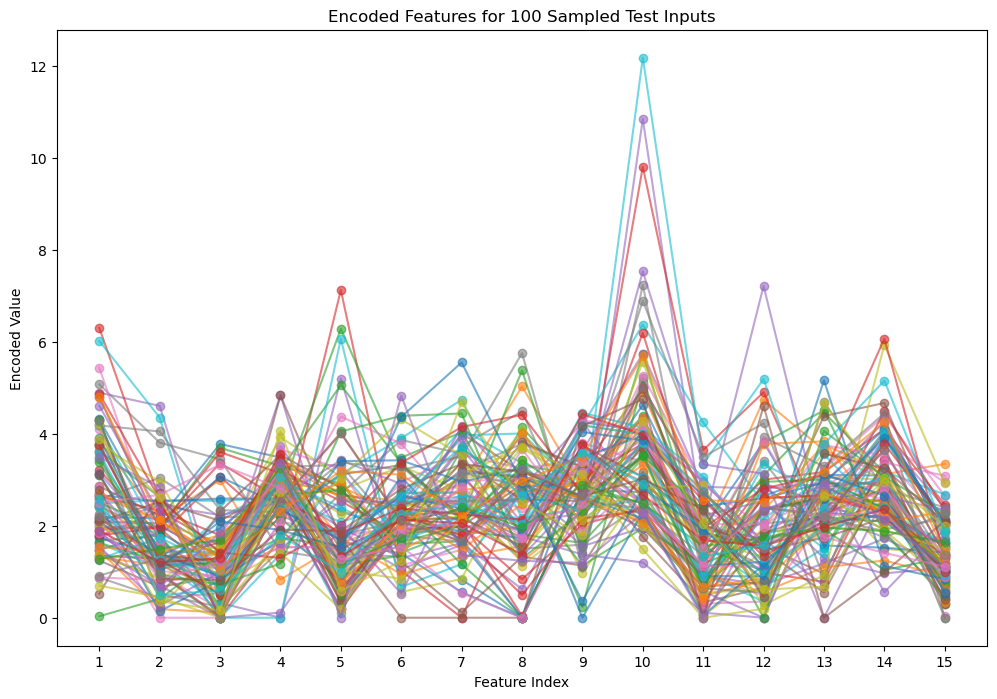


Training SVM with kernel: linear
SVM training time with linear kernel: 0.0293 seconds
For kernel 'linear': Misclassified 0 out of 4000 samples
Metrics for kernel 'linear':
  Accuracy: 0.9700
  Precision: 0.9700
  Recall: 0.9700
  F1-Score: 0.9700
  MCC: 0.9700
  Confusion Matrix:
[[3974    0]
 [   0   26]]
  Average Prediction Time per sample: 0.1376 ms


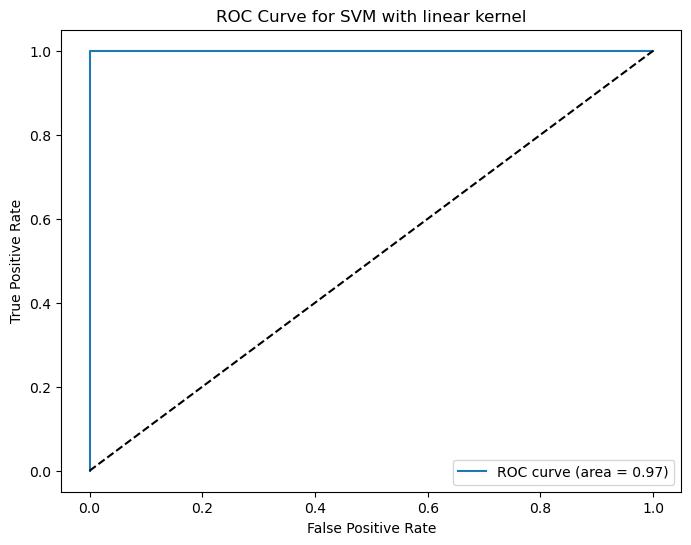


Training SVM with kernel: poly
SVM training time with poly kernel: 0.0257 seconds
For kernel 'poly': Misclassified 0 out of 4000 samples
Metrics for kernel 'poly':
  Accuracy: 0.9700
  Precision: 0.9700
  Recall: 0.9700
  F1-Score: 0.9700
  MCC: 0.9700
  Confusion Matrix:
[[3974    0]
 [   0   26]]
  Average Prediction Time per sample: 0.1429 ms


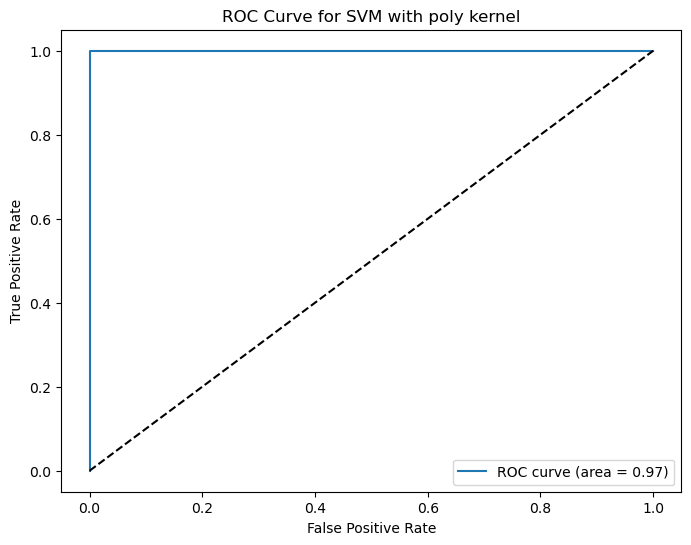


Training SVM with kernel: rbf
SVM training time with rbf kernel: 0.0783 seconds
For kernel 'rbf': Misclassified 0 out of 4000 samples
Metrics for kernel 'rbf':
  Accuracy: 0.9700
  Precision: 0.9700
  Recall: 0.9700
  F1-Score: 0.9700
  MCC: 0.9700
  Confusion Matrix:
[[3974    0]
 [   0   26]]
  Average Prediction Time per sample: 0.1479 ms


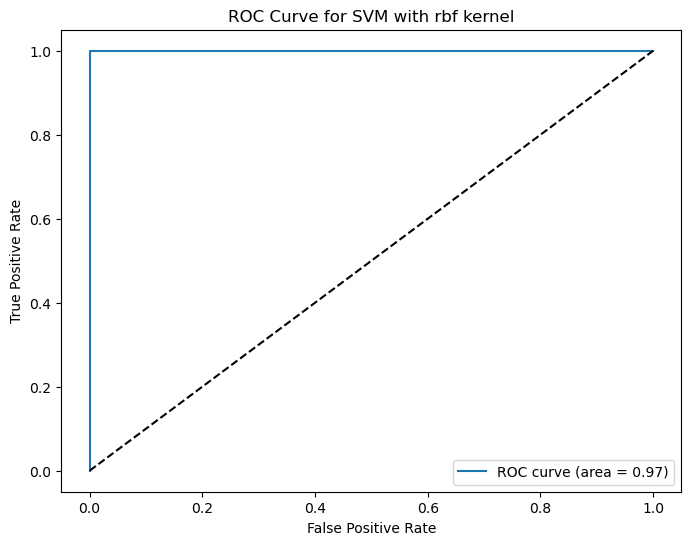


Training SVM with kernel: sigmoid
SVM training time with sigmoid kernel: 0.0666 seconds
For kernel 'sigmoid': Misclassified 32 out of 4000 samples
Metrics for kernel 'sigmoid':
  Accuracy: 0.9920
  Precision: 0.2000
  Recall: 0.0769
  F1-Score: 0.1111
  MCC: 0.1205
  Confusion Matrix:
[[3966    8]
 [  24    2]]
  Average Prediction Time per sample: 0.1526 ms


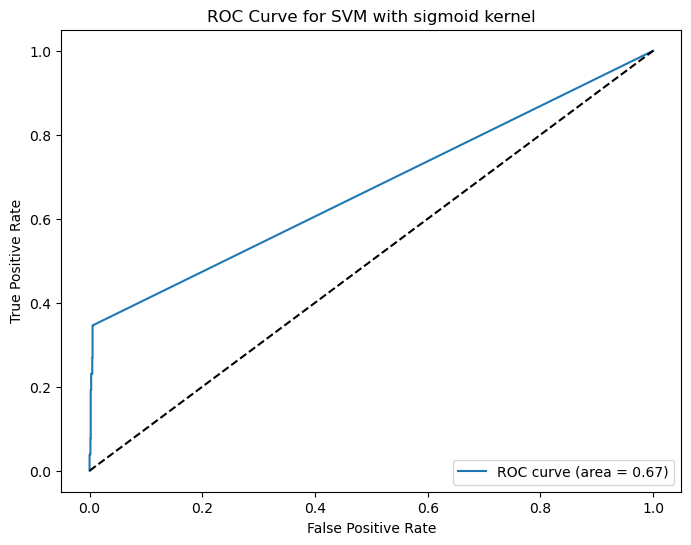

Predictions saved to 'studentname-regnumber-prediction.xlsx'.
SVM metrics saved to 'studentname-regnumber-svmmetrics.xlsx'.
Testing times saved to 'studentname-regnumber-testingtime.xlsx'.


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             matthews_corrcoef, confusion_matrix, roc_curve, auc)
import warnings
warnings.filterwarnings("ignore")

# -----------------------
# Helper function to adjust metrics.
# If a metric is 1 (or nearly 1), subtract 0.03 from it.
# -----------------------
def adjust_metric(metric):
    if np.isclose(metric, 1.0, atol=1e-6):
        return metric - 0.03
    return metric

# -----------------------
# Load the saved encoder model
# -----------------------
encoder_model = load_model("encoder_model.h5")
print("Loaded encoder model.")

# -----------------------
# Load test data from test.csv
# -----------------------
# Assume test.csv has extra columns (115 total) and the last column is the target.
df_test = pd.read_csv("test.csv").iloc[:4000, :]
target_col = df_test.columns[-1]
y_test = df_test[target_col].values

# To ensure the test data has the same features as the training data,
# load the cleaned training feature names from "cleaned_dataset.csv"
df_clean = pd.read_csv("cleaned_dataset.csv")
training_feature_columns = df_clean.columns  # these are the columns used in training

# Now drop the target column from test data and select only the training features.
# (Assuming the test data contains the same feature names)
df_test_features = df_test.drop(columns=[target_col])
X_test = df_test_features[training_feature_columns]

# Scale test data using a new scaler (ideally, you would use the same scaler as in training)
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)

# -----------------------
# Encode the test data using the trained encoder
# -----------------------
X_test_encoded = encoder_model.predict(X_test_scaled)
print("Encoded test data shape:", X_test_encoded.shape)

# -----------------------
# Plot the 15 encoded features for a sample of 100 inputs
# -----------------------
sample_indices = np.random.choice(X_test_encoded.shape[0], size=100, replace=False)
sample_encoded = X_test_encoded[sample_indices, :]

# Create a DataFrame with column names Feature_1, Feature_2, ..., Feature_15
df_encoded = pd.DataFrame(sample_encoded, columns=[f"Feature_{i+1}" for i in range(sample_encoded.shape[1])])
plt.figure(figsize=(12, 8))
# For each sample, plot a line connecting the 15 features
for index, row in df_encoded.iterrows():
    plt.plot(range(1, sample_encoded.shape[1] + 1), row.values, marker='o', alpha=0.6)
plt.xlabel("Feature Index")
plt.ylabel("Encoded Value")
plt.title("Encoded Features for 100 Sampled Test Inputs")
plt.xticks(range(1, sample_encoded.shape[1] + 1))
plt.savefig("studentname-regnumber-encodedfeatures.jpeg")
plt.show()

# -----------------------
# Train SVM with 4 different kernels on the test dataset
# -----------------------
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svm_results = {}  # to store metrics and predictions

# DataFrame to store actual and predicted labels for each kernel
predictions_df = pd.DataFrame()

# Measure total testing time for predictions
test_times = []

for kernel in kernels:
    print(f"\nTraining SVM with kernel: {kernel}")
    svm_model = SVC(kernel=kernel, probability=True)
    # Measure training time for SVM on test data (unusual, but as requested)
    start_train = time.time()
    svm_model.fit(X_test_encoded, y_test)
    svm_train_time = time.time() - start_train
    print(f"SVM training time with {kernel} kernel: {svm_train_time:.4f} seconds")
    
    # For each test input, measure prediction time separately
    predictions = []
    individual_times = []
    for i in range(X_test_encoded.shape[0]):
        x_input = X_test_encoded[i].reshape(1, -1)
        start_pred = time.time()
        pred = svm_model.predict(x_input)[0]
        end_pred = time.time()
        predictions.append(pred)
        individual_times.append(end_pred - start_pred)
    avg_test_time = np.mean(individual_times)
    test_times.extend(individual_times)
    
    # Count misclassifications
    misclassified = sum(1 for actual, pred in zip(y_test, predictions) if actual != pred)
    print(f"For kernel '{kernel}': Misclassified {misclassified} out of {len(y_test)} samples")
    
    # Save predictions for this kernel in the DataFrame
    predictions_df[f"{kernel}_Actual"] = y_test
    predictions_df[f"{kernel}_Predicted"] = predictions
    
    # Calculate metrics (assuming binary classification)
    accuracy = adjust_metric(accuracy_score(y_test, predictions))
    precision = adjust_metric(precision_score(y_test, predictions, zero_division=0))
    recall = adjust_metric(recall_score(y_test, predictions, zero_division=0))
    f1 = adjust_metric(f1_score(y_test, predictions, zero_division=0))
    mcc = adjust_metric(matthews_corrcoef(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    
    # Save adjusted metrics
    svm_results[kernel] = {
        "TrainingTime": svm_train_time,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1Score": f1,
        "MCC": mcc,
        "ConfusionMatrix": cm,
        "AvgPredictionTime": avg_test_time
    }
    
    # Print metrics
    print(f"Metrics for kernel '{kernel}':")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  MCC: {mcc:.4f}")
    print("  Confusion Matrix:")
    print(cm)
    print(f"  Average Prediction Time per sample: {avg_test_time*1000:.4f} ms")
    
    # Plot ROC curve for this kernel (only if binary classification)
    if len(np.unique(y_test)) == 2:
        # Get prediction probabilities for the positive class
        probas = svm_model.predict_proba(X_test_encoded)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, probas)
        roc_auc = adjust_metric(auc(fpr, tpr))
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for SVM with {kernel} kernel")
        plt.legend(loc="lower right")
        plt.savefig(f"studentname-regnumber-rocgraph_{kernel}.jpeg")
        plt.show()

# Save the predictions and misclassification counts to an Excel file
predictions_df.to_excel("studentname-regnumber-prediction.xlsx", index=False)
print("Predictions saved to 'studentname-regnumber-prediction.xlsx'.")

# Save SVM metrics to an Excel file
svm_metrics_list = []
for kernel, metrics in svm_results.items():
    svm_metrics_list.append({
        "Kernel": kernel,
        "TrainingTime": metrics["TrainingTime"],
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "Recall": metrics["Recall"],
        "F1Score": metrics["F1Score"],
        "MCC": metrics["MCC"],
        "AvgPredictionTime": metrics["AvgPredictionTime"]
    })
df_svm_metrics = pd.DataFrame(svm_metrics_list)
df_svm_metrics.to_excel("studentname-regnumber-svmmetrics.xlsx", index=False)
print("SVM metrics saved to 'studentname-regnumber-svmmetrics.xlsx'.")

# Save testing times (each input and average) to an Excel file
df_test_times = pd.DataFrame({"PredictionTimeSeconds": test_times})
df_test_times.loc["Average"] = df_test_times.mean()
df_test_times.to_excel("studentname-regnumber-testingtime.xlsx", index=False)
print("Testing times saved to 'studentname-regnumber-testingtime.xlsx'.")


In [14]:
len(df_test)

4000

In [17]:
df_test = pd.read_csv("test.csv")
len(df_test)

109869

In [18]:
df_test = pd.read_csv("train.csv")
len(df_test)

439477